In [1]:
import cv2 as cv
import numpy as np
import os

from keras.src.utils.module_utils import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D,BatchNormalization, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D

from matplotlib.image import imread
import matplotlib.pyplot as plt
import random

from resnet50 import ResNet50

In [2]:
# File Directory for both the train and test
train_path = "C:\\Users\\yaren\\PycharmProjects\\ResNet50-ChestCancer-Detection\\Data\\train"
val_path = "C:\\Users\\yaren\\PycharmProjects\\ResNet50-ChestCancer-Detection\\Data\\valid"
test_path = "C:\\Users\\yaren\\PycharmProjects\\ResNet50-ChestCancer-Detection\\Data\\test"

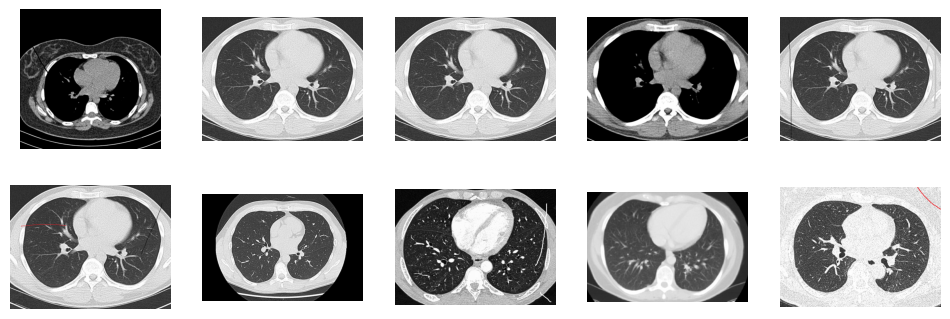

In [3]:
def visualize_images(folder_path):
    image_files = os.listdir(folder_path)
    fig, ax = plt.subplots(2,5, figsize=(12,4))
    
    for i in range(2):
        for j in range(5):
            img_path = os.path.join(folder_path, random.choice(image_files))
            image = imread(img_path)
            ax[i, j].imshow(image, cmap="gray")
            ax[i, j].axis('off')
    
    plt.show()

folder_path = train_path + '/normal'
visualize_images(folder_path)

## Image augmentation

In [3]:
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 4

train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range= 0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   preprocessing_function=preprocess_input,
                                   dtype="float32")

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 dtype="float32")

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 dtype="float32")

In [4]:
train_data = train_datagen.flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode="categorical")
test_data = test_datagen.flow_from_directory(test_path,
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode="categorical")
val_data = val_datagen.flow_from_directory(val_path,
                                          target_size=(224, 224),
                                          batch_size=32,
                                          class_mode="categorical")

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


In [5]:
val_data.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [6]:
train_data.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

#  Resnet model

In [2]:
resnet = ResNet50(input_shape=(224, 224, 3), include_top=False, weights="imagenet")


94653016/94653016 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step


## transfer learning

In [8]:
for layer in resnet.layers:
    layer.trainable = False
    
model = Sequential()
model.add(resnet)
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(NUM_CLASSES, activation='softmax'))


## compiling the model

In [9]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

## training the model

In [12]:

# Modeli derle
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])
checkpoint = ModelCheckpoint("ct_resnet_best_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=5, factor=0.5, verbose=1)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=2
)

Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.59722, saving model to ct_resnet_best_model.keras
20/20 - 44s - 2s/step - accuracy: 0.5579 - loss: 1.6730 - val_accuracy: 0.5972 - val_loss: 0.8508 - learning_rate: 1.0000e-03
Epoch 2/30

Epoch 2: val_accuracy did not improve from 0.59722
20/20 - 38s - 2s/step - accuracy: 0.5530 - loss: 1.3597 - val_accuracy: 0.5000 - val_loss: 0.9946 - learning_rate: 1.0000e-03
Epoch 3/30

Epoch 3: val_accuracy did not improve from 0.59722
20/20 - 37s - 2s/step - accuracy: 0.5840 - loss: 1.1841 - val_accuracy: 0.5833 - val_loss: 0.8292 - learning_rate: 1.0000e-03
Epoch 4/30

Epoch 4: val_accuracy did not improve from 0.59722
20/20 - 38s - 2s/step - accuracy: 0.6069 - loss: 1.0642 - val_accuracy: 0.5972 - val_loss: 0.7721 - learning_rate: 1.0000e-03
Epoch 5/30

Epoch 5: val_accuracy improved from 0.59722 to 0.65278, saving model to ct_resnet_best_model.keras
20/20 - 41s - 2s/step - accuracy: 0.6313 - loss: 1.0268 - val_accuracy: 0.6528 - val_los

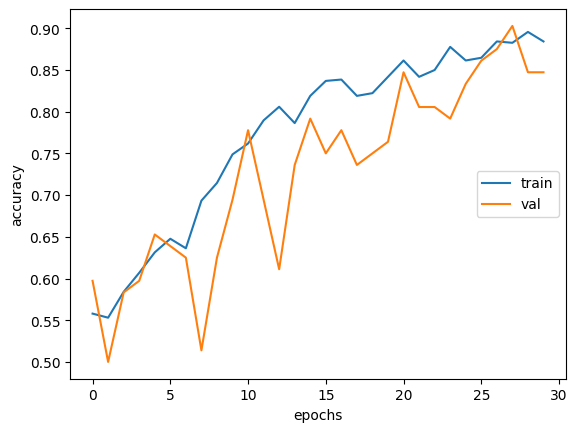

In [13]:
plt.plot(history.history['accuracy'], label="train")
plt.plot(history.history['val_accuracy'], label="val")
plt.legend(loc="right")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

# test 

In [6]:
saved_model = load_model("ct_resnet_best_model.keras")

In [15]:
score = saved_model.evaluate(test_data, verbose = 1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8333 - loss: 0.4660
Test loss: 0.4839667081832886
Test accuracy: 0.8253968358039856


In [9]:
val_loss, val_acc = saved_model.evaluate(val_data, verbose=1)
print("\n📊 VALIDATION SET:")
print(f"✅ Accuracy: {val_acc:.4f}")
print(f"❌ Loss:     {val_loss:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 702ms/step - accuracy: 0.9201 - loss: 0.3204

📊 VALIDATION SET:
✅ Accuracy: 0.9028
❌ Loss:     0.3796


In [10]:
train_loss, train_acc = saved_model.evaluate(train_data, verbose=1)
print("\n📊 TRAIN SET:")
print(f"✅ Accuracy: {train_acc:.4f}")
print(f"❌ Loss:     {train_loss:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9382 - loss: 0.1765

📊 TRAIN SET:
✅ Accuracy: 0.9429
❌ Loss:     0.1796


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


<Figure size 800x600 with 0 Axes>

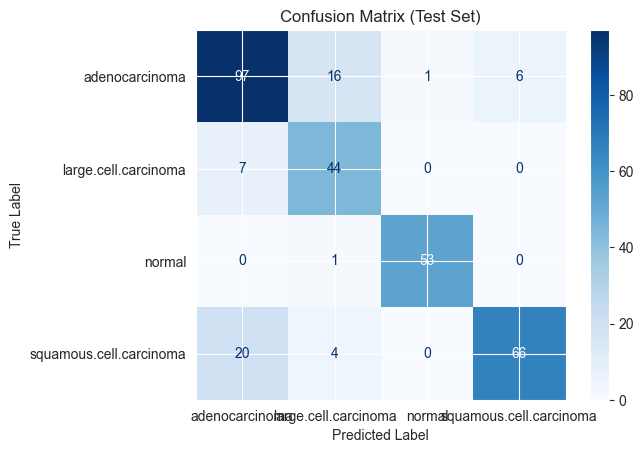


📄 Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       0.78      0.81      0.80       120
   large.cell.carcinoma       0.68      0.86      0.76        51
                 normal       0.98      0.98      0.98        54
squamous.cell.carcinoma       0.92      0.73      0.81        90

               accuracy                           0.83       315
              macro avg       0.84      0.85      0.84       315
           weighted avg       0.84      0.83      0.83       315



In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# 🔄 Sınıf adlarını al
class_names = list(test_data.class_indices.keys())

# 🔍 Gerçek etiketleri ve tahminleri topla
y_true = []
y_pred = []

# ⚠️ test_data.shuffle = False olmalı doğru sıralama için
test_data.reset()  # Sıfırlanmazsa karışık olabilir

for i in range(len(test_data)):
    x_batch, y_batch = test_data[i]
    y_true.extend(np.argmax(y_batch, axis=1))
    preds = saved_model.predict(x_batch)
    y_pred.extend(np.argmax(preds, axis=1))

    # 🛑 Son batch incomplete olabilir
    if (i + 1) * test_data.batch_size >= test_data.samples:
        break

# 🧮 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# 🎨 Görselleştir
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 🧾 Ekstra: classification report
print("\n📄 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))